# Plotting and sampling values from raster

### Import libreries

In [1]:
import geopandas
import rasterio
import matplotlib.pyplot as plt
from rasterio import plot
import numpy as np
import pandas as pd
from rasterio.mask import mask
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Import SHP file

In [3]:
my_shp = geopandas.read_file(r"C:\Users\larth\Documents\MAD-lab\data\fakesite_01.shp")

In [4]:
my_shp

,id,nome,geometry
0,None,fake_01,POINT (10.74217 44.57479)
1,None,fake_02,POINT (10.81302 44.61937)
2,None,fake_03,POINT (10.88998 44.50080)
3,None,fake_04,POINT (10.82486 44.57091)


### Import Raster file

In [5]:
my_raster = rasterio.open(r"C:\Users\larth\Documents\MAD-lab\data\dtm_srtm_90.tif")

#### A simple function for plotting raster and shp

In [6]:
def GeoPlot(vector, raster):
    fig, ax = plt.subplots(figsize = (10,10))
    # raster
    plot.show(raster, ax = ax)
    # vector
    vector.plot(ax = ax)
    

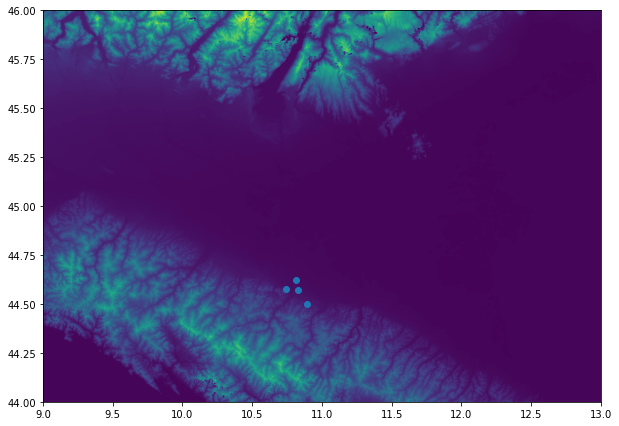

In [7]:
GeoPlot(my_shp, my_raster)

#### A simple function for sampling values by a raster

In [8]:
def SamplingValues(shp, raster):
    values = []
    new_shp = shp.copy()
    for i in range (0, len(shp)):
        for val in raster.sample([(shp.geometry.x[i], shp.geometry.y[i])]): 
            values.append(float(val))
    return values
            
        

In [9]:
my_val = SamplingValues(my_shp, my_raster)

In [10]:
my_val

[116.0, 59.0, 187.0, 90.0]

In [11]:
my_shp["values"] = my_val

In [12]:
my_shp

,id,nome,geometry,values
0,None,fake_01,POINT (10.74217 44.57479),116.0
1,None,fake_02,POINT (10.81302 44.61937),59.0
2,None,fake_03,POINT (10.88998 44.50080),187.0
3,None,fake_04,POINT (10.82486 44.57091),90.0


#### Plotting buffers?

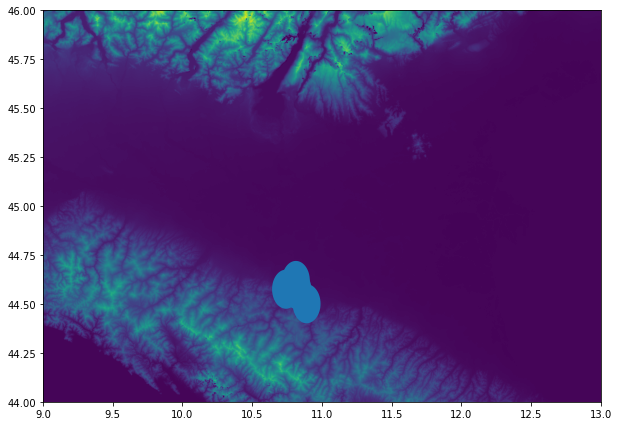

In [13]:
GeoPlot(my_shp.buffer(0.1), my_raster)

### Buffer stats

In [14]:
def Zonal_stats(vector, raster, buffer_size=0.1, plot_img_hist=True):
    zonal_stats_list = []
    vector_func = vector.copy()
    vector_func["buffer"] = vector_func.buffer(buffer_size)
    for n in range(0, len(vector_func)):
        selected_site = vector_func.iloc[n:n+1]
        out_img, out_transform = mask(raster, selected_site["buffer"], crop=True, filled=False)
        # statistics ADD MORE?
        img_mean = np.mean(out_img)
        img_median = np.median(out_img)
        img_std = np.std(out_img)
        

        zonal_stats_list.append((img_mean, img_median, img_std))
        zonal_df = pd.DataFrame(zonal_stats_list, columns=("mean", "median", "std"))

        zonal_stats_df = vector_func.join(zonal_df)

        if plot_img_hist:
            plot_title = (f"index: {n}")
            plt.suptitle(plot_title)
            fig, ax = plt.subplots(1, 2, figsize=(10, 5),
            #subplot_kw={'xticks':[], 'yticks':[]},
            gridspec_kw=dict(hspace=0.05, wspace=0.25))
            ax[0] = plot.show(out_img, transform=out_transform, ax = ax[0])
            ax[0] = selected_site.plot(ax = ax[0])
            ax[1] = sns.histplot(out_img.reshape(-1), ax = ax[1])
        
    return zonal_stats_df



,id,nome,geometry,values,buffer,mean,median,std
0,None,fake_01,POINT (10.74217 44.57479),116.0,"POLYGON ((10.84217 44.57479, 10.84169 44.56499...",146.653140,110.0,93.887609
1,None,fake_02,POINT (10.81302 44.61937),59.0,"POLYGON ((10.91302 44.61937, 10.91254 44.60957...",68.447377,56.0,36.808336
2,None,fake_03,POINT (10.88998 44.50080),187.0,"POLYGON ((10.98998 44.50080, 10.98949 44.49100...",218.426575,172.0,144.633978
3,None,fake_04,POINT (10.82486 44.57091),90.0,"POLYGON ((10.92486 44.57091, 10.92438 44.56110...",118.533385,87.0,87.306292


<Figure size 432x288 with 0 Axes>

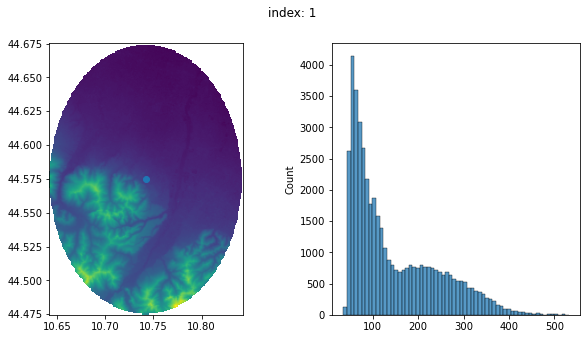

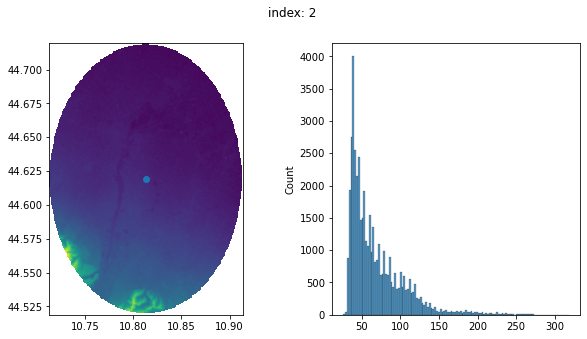

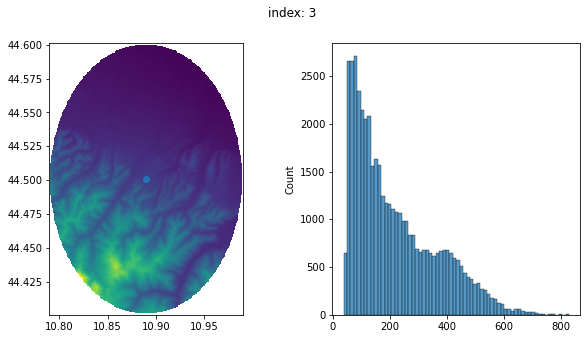

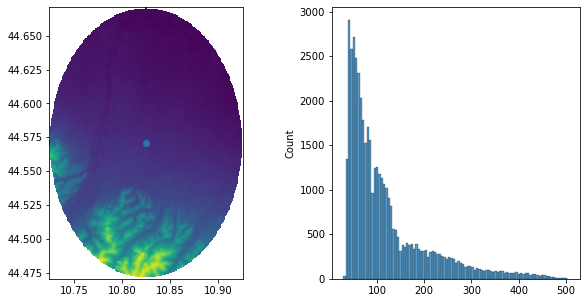

In [15]:
# Plot results
Zonal_stats(my_shp, my_raster)

In [16]:
# Save results in a variable
table = Zonal_stats(my_shp, my_raster, plot_img_hist=False)

In [17]:
table

,id,nome,geometry,values,buffer,mean,median,std
0,None,fake_01,POINT (10.74217 44.57479),116.0,"POLYGON ((10.84217 44.57479, 10.84169 44.56499...",146.653140,110.0,93.887609
1,None,fake_02,POINT (10.81302 44.61937),59.0,"POLYGON ((10.91302 44.61937, 10.91254 44.60957...",68.447377,56.0,36.808336
2,None,fake_03,POINT (10.88998 44.50080),187.0,"POLYGON ((10.98998 44.50080, 10.98949 44.49100...",218.426575,172.0,144.633978
3,None,fake_04,POINT (10.82486 44.57091),90.0,"POLYGON ((10.92486 44.57091, 10.92438 44.56110...",118.533385,87.0,87.306292
